In [1]:
#Trata-se de uma questão de classificação, dessa forma ire começar fazendo uma análise exploratória voltada para esse tipo de 
#Condição

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, roc_curve, roc_auc_score
from xgboost import XGBClassifier
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings(action = "ignore")

In [4]:
rawData = pd.read_csv("projeto4_telecom_treino.csv")
rawData.head(5)

Unnamed: 0 state  account_length      area_code international_plan  \
0           1    KS             128  area_code_415                 no   
1           2    OH             107  area_code_415                 no   
2           3    NJ             137  area_code_415                 no   
3           4    OH              84  area_code_408                yes   
4           5    OK              75  area_code_415                yes   

  voice_mail_plan  number_vmail_messages  total_day_minutes  total_day_calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total_day_charge  ...  total_eve_calls  total_eve_charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total_night_minutes  total_night_calls  total_night_charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   number_customer_service_calls  churn  
0                              1     no  
1                              1     no  
2                              0     no  
3                              2     no  
4                              3     no  

[5 rows x 21 columns]

In [5]:
rawData.columns

Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [6]:
rawData.shape

(3333, 21)

In [7]:
# Aqui vejo que o dataset não possui valores missing, o que é muito bom
pd.isna(rawData).sum().sum()

0

In [8]:
# a colunas unnamed é apenas um índice, dessa forma não contribui para o algoritmo
del rawData["Unnamed: 0"]

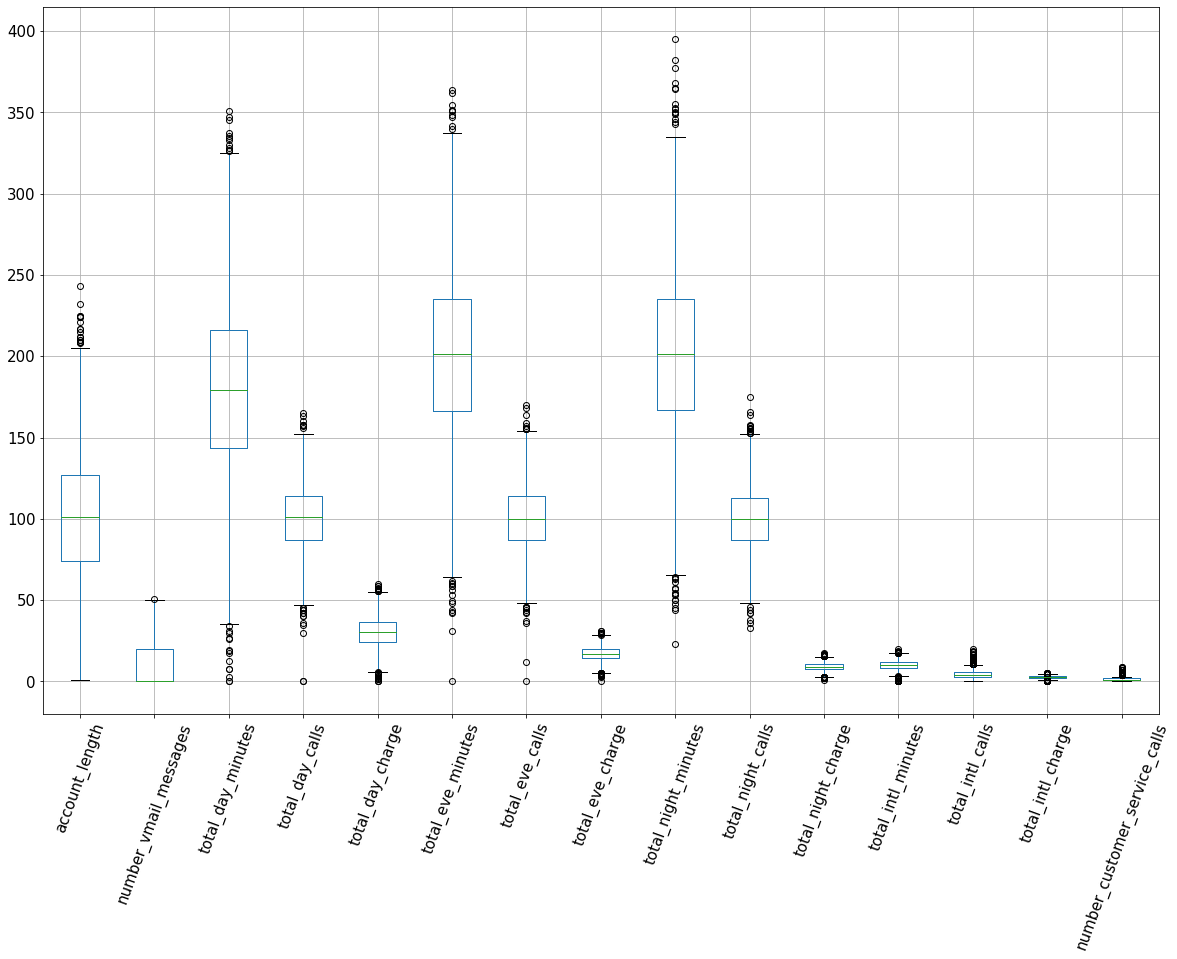

In [9]:
# iniciamos fazendo apenas um boxplot das variáveis, nesse caso só irão aparecer as variáveis numéricas
figure = plt.figure(figsize = (20,13))
rawData.boxplot(rot = 70, fontsize=15)
plt.show()

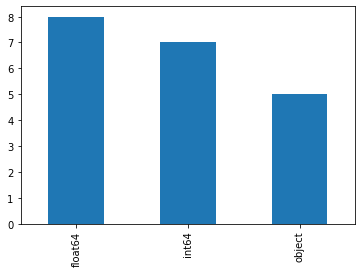

In [10]:
#Vejo também que existem algumas colunas não numéricas, devo então iniciar algum tipo de tratamento afim de verificar se é possível
# fazer algum tipo de adaptação nos dados
rawData.dtypes.value_counts().plot.bar()

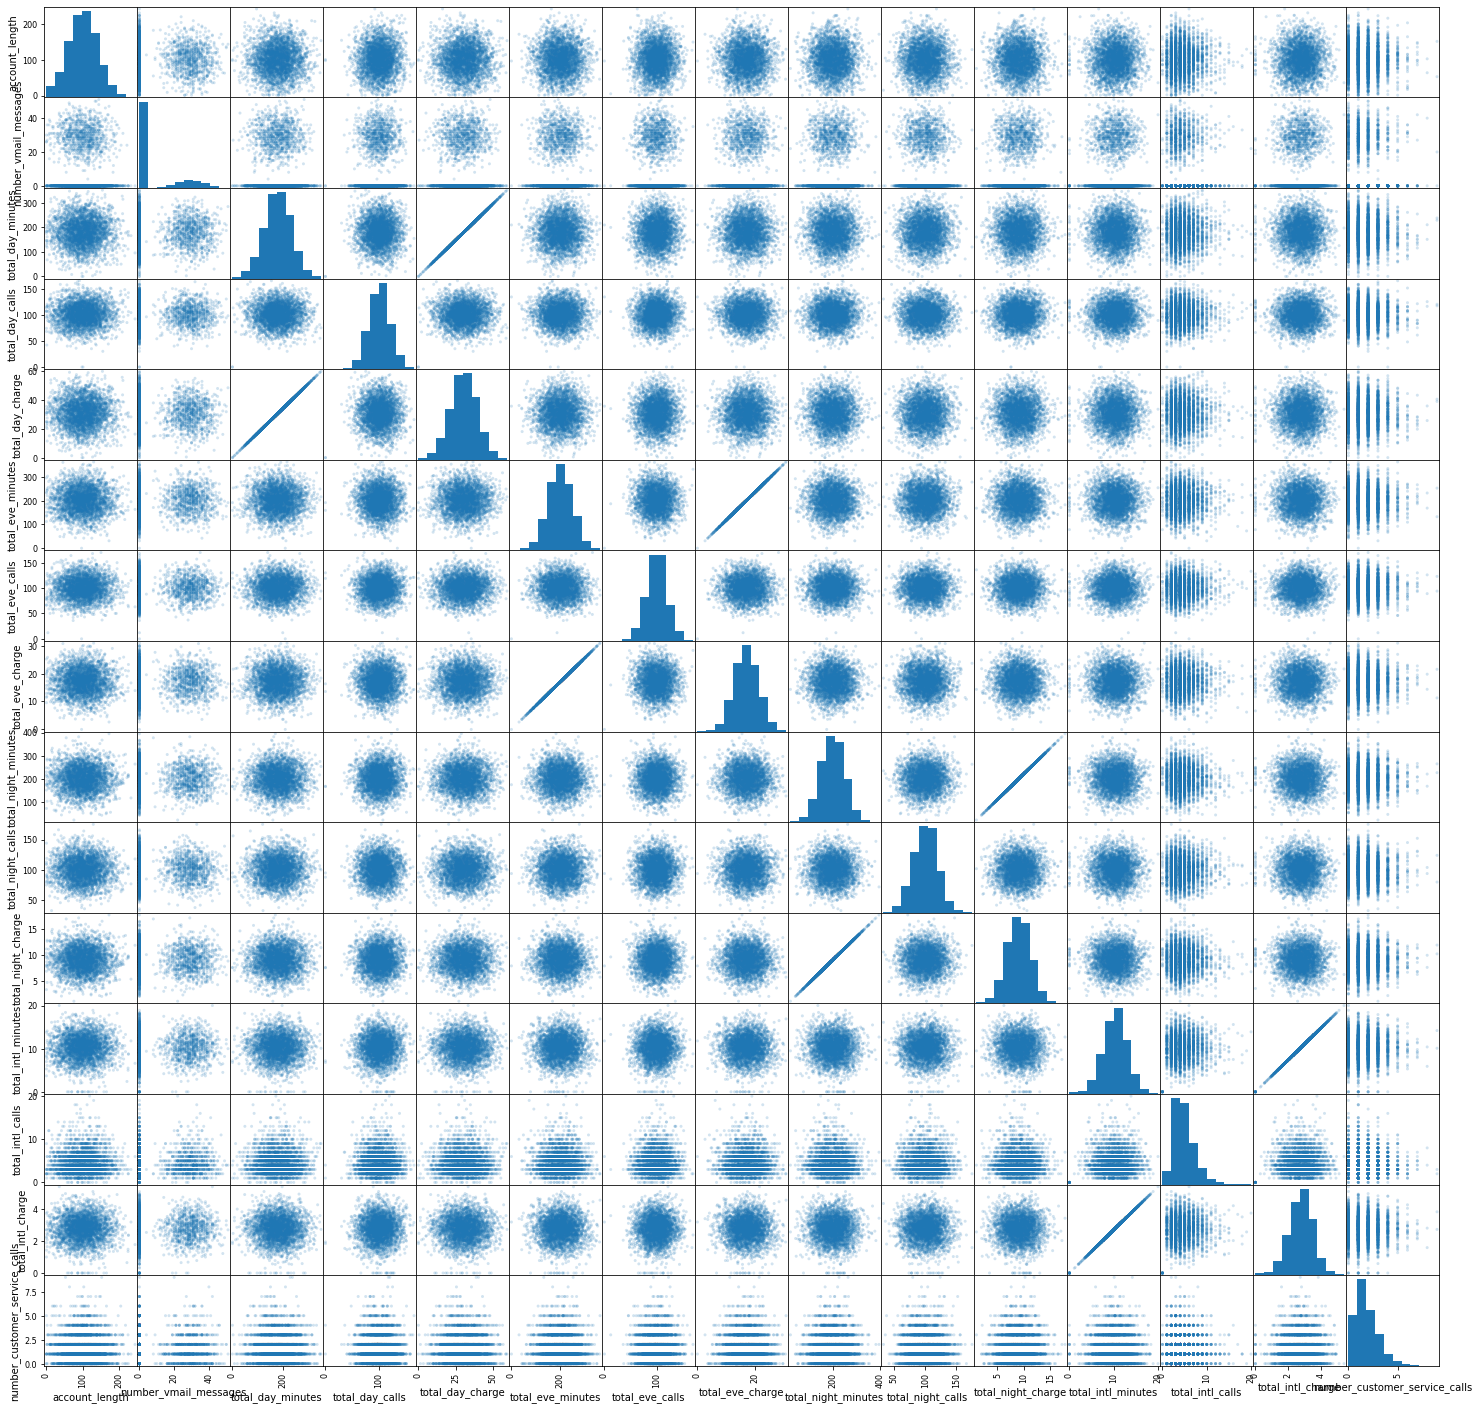

In [11]:
# também irei utilizar um scatter_matrix afim de visualizar como está a distribuição dos dados
pd.plotting.scatter_matrix(rawData, alpha = 0.2, figsize = (25,25));

In [12]:
# além de plotar a matriz de correlação ainda com os dados brutos
corr = rawData.corr()

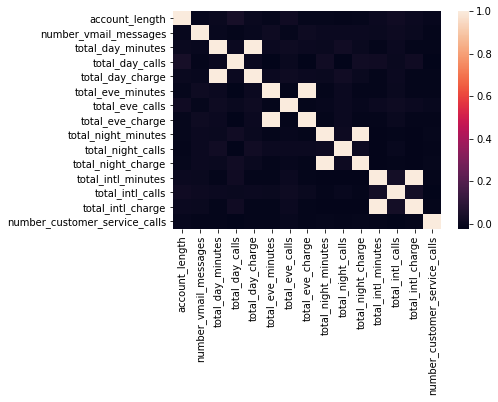

In [13]:
sns.heatmap(corr)

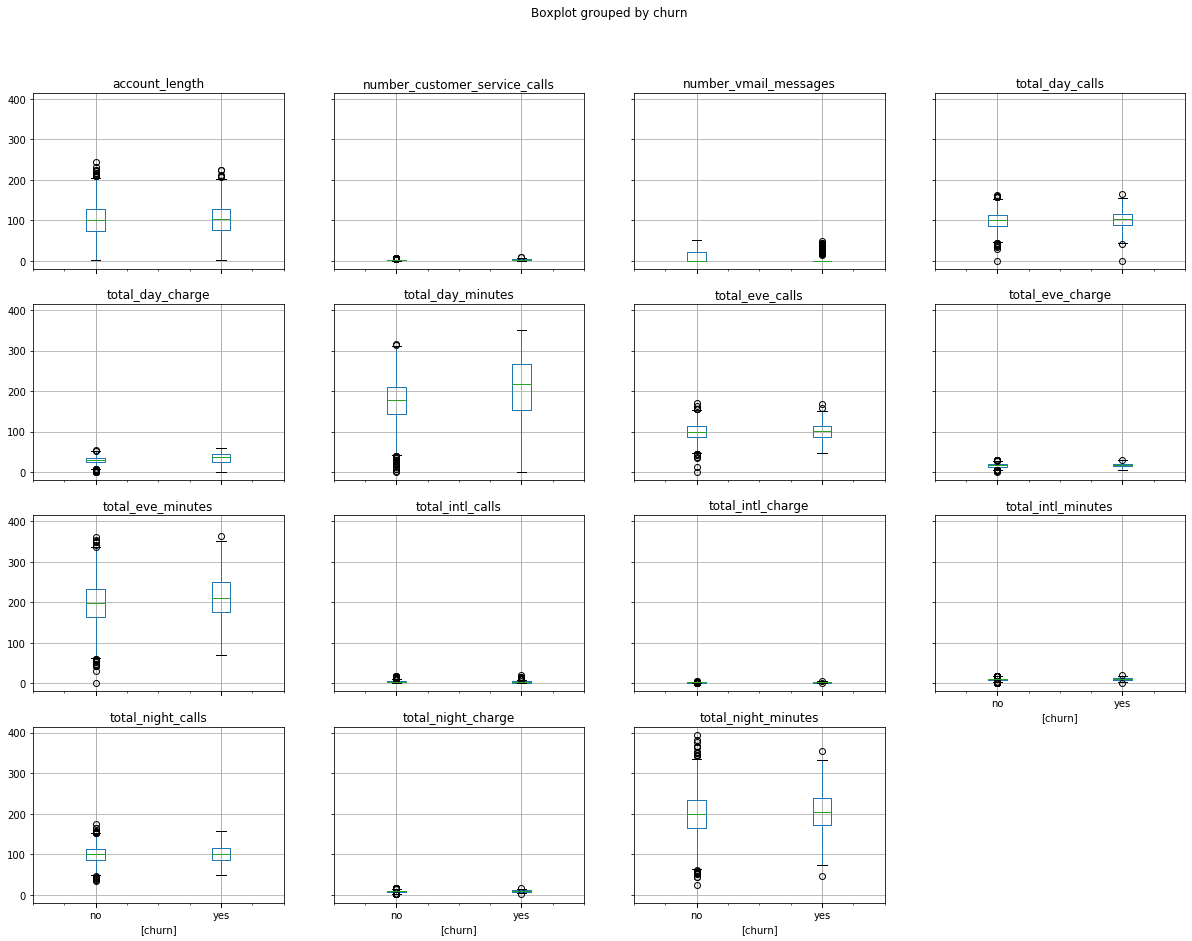

In [14]:
# o objetivo desse gráfico é verificar se existe alguma relação entre das variáveis apresentadas e a variável alvo
# numa análise superficial podemos verificar que os usuários que utilizam mais minutos tendem a ter um churn maior
rawData.boxplot(by = 'churn', figsize = (20,15));

In [15]:
# aqui apenas verificando quais colunas não são numéricas para poder realizar um tratamento nos dados
colunasObjecto = []
for coluna in rawData.columns:
    if rawData[coluna].dtype == 'object':
        colunasObjecto.append(coluna)
colunasObjecto

['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']

In [16]:
# Coletando os valores contidos nas colunas não-numéricas
states = pd.Series(rawData.state.unique())
states
areaCodes = rawData.area_code.unique()
areaCodes
intPlans = rawData.international_plan.unique()
intPlans
voiceMPlan = rawData.voice_mail_plan.unique()
voiceMPlan
churn_ = rawData.churn.unique()
churn_

array(['no', 'yes'], dtype=object)

In [17]:
type(states)

pandas.core.series.Series

In [18]:
rawData.head(5)

state  account_length      area_code international_plan voice_mail_plan  \
0    KS             128  area_code_415                 no             yes   
1    OH             107  area_code_415                 no             yes   
2    NJ             137  area_code_415                 no              no   
3    OH              84  area_code_408                yes              no   
4    OK              75  area_code_415                yes              no   

   number_vmail_messages  total_day_minutes  total_day_calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   total_night_minutes  total_night_calls  total_night_charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total_intl_minutes  total_intl_calls  total_intl_charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   number_customer_service_calls churn  
0                              1    no  
1                              1    no  
2                              0    no  
3                              2    no  
4                              3    no

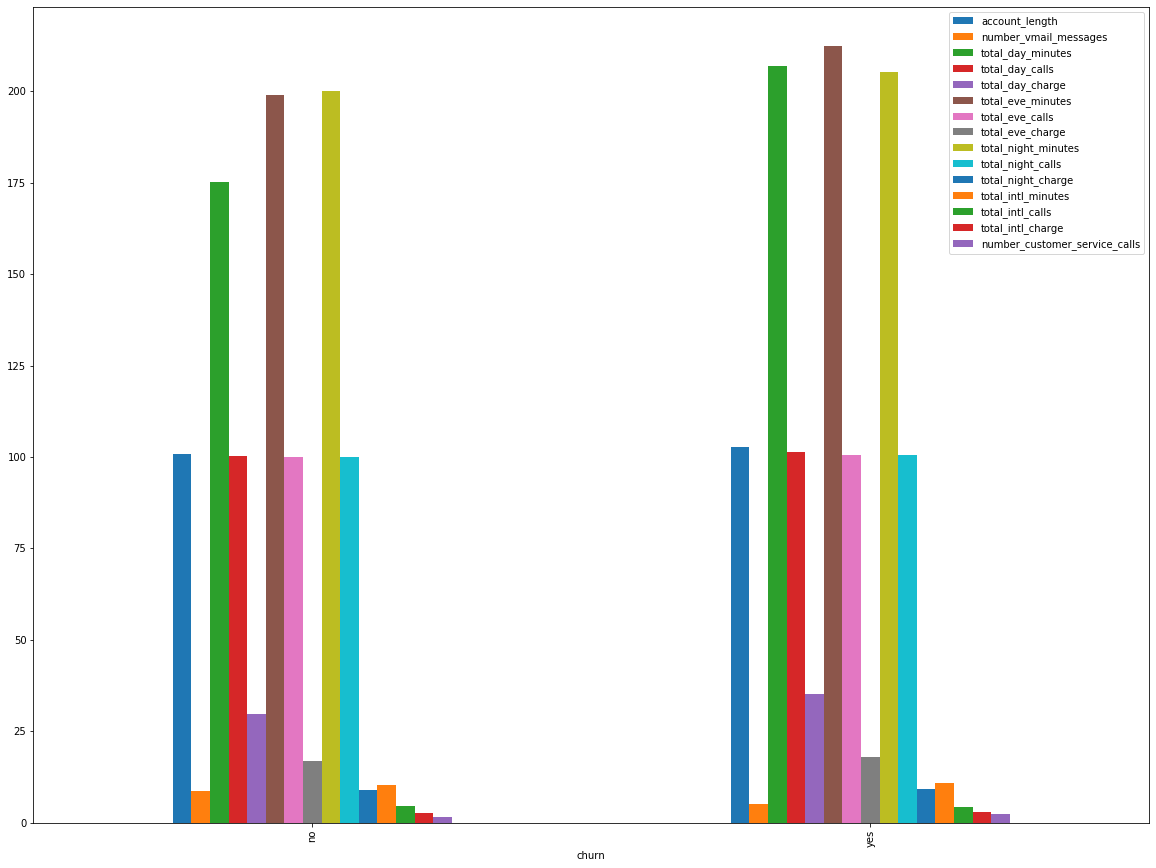

In [19]:
# irei utilizar a média agregada pelo target afim de verificar quais parâmetros são mais significantes
# Algumas variáveis chamam atenção
rawData.groupby('churn').agg("mean").plot.bar(by = 'churn', figsize = (20,15))

In [20]:
#Aqui irei calcuar o churn relativo por estado afim de verificar se há algum estado com churn maior que outros
#Estou usando o churn relativo pois a contagem pode não refletir a discrepância real entre um estado e o outro caso alguns
# estados tenham mais amostras
churnRelativoPorEstado =  (rawData[rawData['churn'] == 'yes'].groupby('state')['churn'].count()/rawData.groupby("state")["churn"].count())*100
#churnRelativoPorEstado.plot.bar(figsize = (20,15))

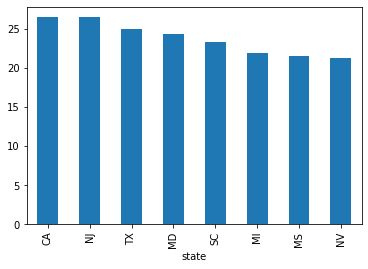

In [21]:
# Estados com o maior churn
churnRelativoPorEstado.sort_values(ascending=False).head(8).plot.bar()

In [22]:
# Algumas colunas apresentam valores não-numéricos o que pode dificultar a análise
# da forma como está não vejo motivos para não converter para valores numéricos, assim sendo o farei e as funções abaixo
# realizam exatamente isto

def convertAreaCode(valor):
    retorno = 0
    if valor =='area_code_408':
        retorno = 0
    elif valor =='area_code_415':
        retorno = 1
    elif valor =="area_code_510":
        retorno =2
    return retorno
    
def retornaConformeIdx(valor):
    # a variável "states" deve ser uma série do pandas
    return states[states == valor].index[0]
    
def transformDataset(dataset):
    copia = dataset.copy()
    colunasYesNo = ['international_plan', 'voice_mail_plan', 'churn']
    for coluna in colunasYesNo:
        copia[coluna] = copia[coluna].map(lambda x: 1 if x == "yes" else 0)
   
    copia["state"] = copia['state'].map(retornaConformeIdx)
    copia["area_code"] = copia['area_code'].map(convertAreaCode)    
    
    return copia

In [23]:
# Basicamente utilizando as funções definidas acima para transformar os dados de tipo object para numéricos
datasetAjustado = transformDataset(rawData)
datasetAjustado

state  account_length  area_code  international_plan  voice_mail_plan  \
0         0             128          1                   0                1   
1         1             107          1                   0                1   
2         2             137          1                   0                0   
3         1              84          0                   1                0   
4         3              75          1                   1                0   
...     ...             ...        ...                 ...              ...   
3328     20             192          1                   0                1   
3329      8              68          1                   0                0   
3330     10              28          2                   0                0   
3331     49             184          2                   1                0   
3332     47              74          1                   0                1   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                        25              265.1              110   
1                        26              161.6              123   
2                         0              243.4              114   
3                         0              299.4               71   
4                         0              166.7              113   
...                     ...                ...              ...   
3328                     36              156.2               77   
3329                      0              231.1               57   
3330                      0              180.8              109   
3331                      0              213.8              105   
3332                     25              234.4              113   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                45.07              197.4               99             16.78   
1                27.47              195.5              103             16.62   
2                41.38              121.2              110             10.30   
3                50.90               61.9               88              5.26   
4                28.34              148.3              122             12.61   
...                ...                ...              ...               ...   
3328             26.55              215.5              126             18.32   
3329             39.29              153.4               55             13.04   
3330             30.74              288.8               58             24.55   
3331             36.35              159.6               84             13.57   
3332             39.85              265.9               82             22.60   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   244.7                 91               11.01   
1                   254.4                103               11.45   
2                   162.6                104                7.32   
3                   196.9                 89                8.86   
4                   186.9                121                8.41   
...                   ...                ...                 ...   
3328                279.1                 83               12.56   
3329                191.3                123                8.61   
3330                191.9                 91                8.64   
3331                139.2                137                6.26   
3332                241.4                 77               10.86   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   10.0                 3               2.70   
1                   13.7                 3               3.70   
2                   12.2                 5               3.29   
3                    6.6                 7               1.78   
4                   10.1                 3               2.73   
...                  ...               ...                ...   
3328               

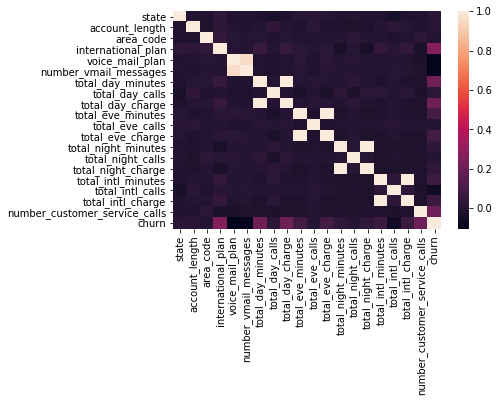

In [24]:
# Agora que temos todas a variáveis como numéricas podemos plotar novamente o mapa de correlação
corrAjustado = datasetAjustado.corr()
sns.heatmap(corrAjustado)

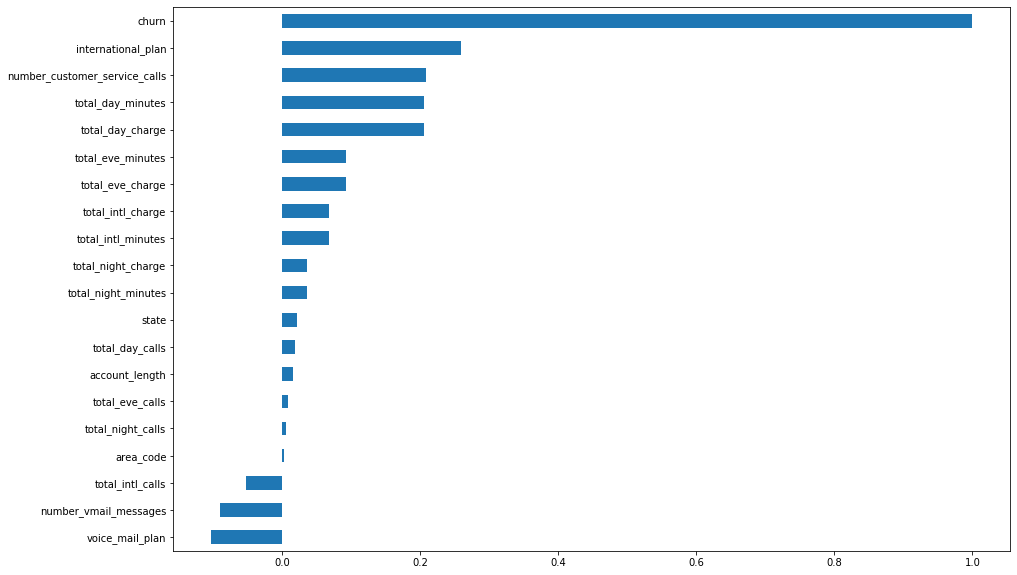

In [25]:
# tentando entender quais variáveis estão mais relacionadas com a variável target
corrAjustado.churn.sort_values().plot.barh(fontsize = 10, figsize = (15,10))

In [26]:
datasetAjustado.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

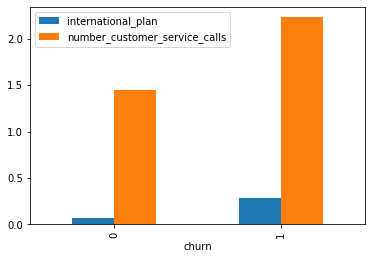

In [27]:
# De acordo com o mapa de correlação as variáveis mais relacionadas com o churn são as variaveis
# international_plan e number_customer_service_calls, Fato que é confirmado pelo gráfico abaixo
datasetAjustado.groupby('churn').agg('mean')[["international_plan","number_customer_service_calls"]].plot.bar()

In [28]:
# Verificando os tipos de dados após a transformação
datasetAjustado.dtypes.value_counts()

int64      12
float64     8
dtype: int64

In [29]:
#A análise exploratória dos dados conclui que as variáveis acima mostradas, tais como
#international_plan , number_customer_service_calls, total_day_charge são as variáveis com maior correlação positiva com a variável alvo
# já as variáveis : voice_mail_plan, number_vmail_messages, total_intl_calls possuem correlação negativa

In [30]:
datasetAjustado.shape

(3333, 20)

In [31]:
x = datasetAjustado.iloc[:,0:19]
y = datasetAjustado.iloc[:,19]

nTrees = 50
seed = 7

model = RandomForestClassifier(n_estimators=nTrees, random_state=seed)
model.fit(x, y)


RandomForestClassifier(n_estimators=50, random_state=7)

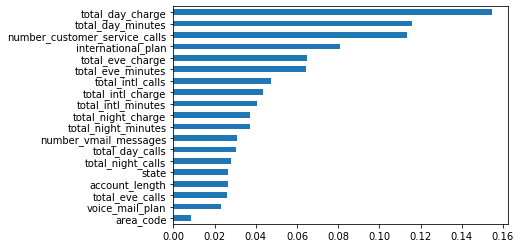

In [32]:
# utilizando o randomforest para tentar entender quais variáveis são mais importantes para a construção do modelo
# o resultado é semelhante ao da tabela de correlação
importanciaDF = pd.DataFrame({"importancia": model.feature_importances_},
                            index=x.columns)
importanciaDF.importancia.sort_values().plot.barh()

# agora iniciar a etapa de análise preditiva com a criação dos modelos

In [33]:
# carregando os dados de teste
rawTestData = pd.read_csv("projeto4_telecom_teste.csv")
rawTestData = rawTestData.drop("Unnamed: 0", axis=1)
rawTestData

state  account_length      area_code international_plan voice_mail_plan  \
0       HI             101  area_code_510                 no              no   
1       MT             137  area_code_510                 no              no   
2       OH             103  area_code_408                 no             yes   
3       NM              99  area_code_415                 no              no   
4       SC             108  area_code_415                 no              no   
...    ...             ...            ...                ...             ...   
1662    HI              50  area_code_408                 no             yes   
1663    WV             152  area_code_415                 no              no   
1664    DC              61  area_code_415                 no              no   
1665    DC             109  area_code_510                 no              no   
1666    VT              86  area_code_415                 no             yes   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                         0               70.9              123   
1                         0              223.6               86   
2                        29              294.7               95   
3                         0              216.8              123   
4                         0              197.4               78   
...                     ...                ...              ...   
1662                     40              235.7              127   
1663                      0              184.2               90   
1664                      0              140.6               89   
1665                      0              188.8               67   
1666                     34              129.4              102   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                12.05              211.9               73             18.01   
1                38.01              244.8              139             20.81   
2                50.10              237.3              105             20.17   
3                36.86              126.4               88             10.74   
4                33.56              124.0              101             10.54   
...                ...                ...              ...               ...   
1662             40.07              223.0              126             18.96   
1663             31.31              256.8               73             21.83   
1664             23.90              172.8              128             14.69   
1665             32.10              171.7               92             14.59   
1666             22.00              267.1              104             22.70   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   236.0                 73               10.62   
1                    94.2                 81                4.24   
2                   300.3                127               13.51   
3                   220.6                 82                9.93   
4                   204.5                107                9.20   
...                   ...                ...                 ...   
1662                297.5                116               13.39   
1663                213.6                113                9.61   
1664                212.4                 97                9.56   
1665                224.4                 89               10.10   
1666                154.8                100                6.97   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   10.6                 3               2.86   
1                    9.5                 7               2.57   
2                   13.7                 6               3.70   
3                   15.7                 2               4.24   
4                    7.7                 4               2.08   
...                  ...               ...                ...   
1662  

In [34]:
# também realizando a mesma transformação feita no dataset de treino
testData = transformDataset(rawTestData)
testData

state  account_length  area_code  international_plan  voice_mail_plan  \
0        24             101          2                   0                0   
1        12             137          2                   0                0   
2         1             103          0                   0                1   
3        41              99          1                   0                0   
4        21             108          1                   0                0   
...     ...             ...        ...                 ...              ...   
1662     24              50          0                   0                1   
1663      8             152          1                   0                0   
1664     43              61          1                   0                0   
1665     43             109          2                   0                0   
1666     15              86          1                   0                1   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                         0               70.9              123   
1                         0              223.6               86   
2                        29              294.7               95   
3                         0              216.8              123   
4                         0              197.4               78   
...                     ...                ...              ...   
1662                     40              235.7              127   
1663                      0              184.2               90   
1664                      0              140.6               89   
1665                      0              188.8               67   
1666                     34              129.4              102   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0                12.05              211.9               73             18.01   
1                38.01              244.8              139             20.81   
2                50.10              237.3              105             20.17   
3                36.86              126.4               88             10.74   
4                33.56              124.0              101             10.54   
...                ...                ...              ...               ...   
1662             40.07              223.0              126             18.96   
1663             31.31              256.8               73             21.83   
1664             23.90              172.8              128             14.69   
1665             32.10              171.7               92             14.59   
1666             22.00              267.1              104             22.70   

      total_night_minutes  total_night_calls  total_night_charge  \
0                   236.0                 73               10.62   
1                    94.2                 81                4.24   
2                   300.3                127               13.51   
3                   220.6                 82                9.93   
4                   204.5                107                9.20   
...                   ...                ...                 ...   
1662                297.5                116               13.39   
1663                213.6                113                9.61   
1664                212.4                 97                9.56   
1665                224.4                 89               10.10   
1666                154.8                100                6.97   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0                   10.6                 3               2.86   
1                    9.5                 7               2.57   
2                   13.7                 6               3.70   
3                   15.7                 2               4.24   
4                    7.7                 4               2.08   
...                  ...               ...                ...   
1662               

In [35]:
# os dados não estão escalados, assim irei construir uma função que irá realizar uma escala nos mesmos de maneira a 
# deixá-los com valores entre 0 - 1
# Porem farei a escala apenas nas colunas que apresentarem valores maiores que 1
def datasetScaler(dataset):
    datasetScaled = dataset.copy()
    numColAjustar = dataset.shape[1]
    colunasMaiores1 = [col for col in dataset.iloc[:,0:numColAjustar].columns if dataset[col].max() >1]
    scaler = MinMaxScaler(feature_range = (0,1))

    toScale = dataset[colunasMaiores1]
    scaled = pd.DataFrame(scaler.fit_transform(toScale), columns=colunasMaiores1)


    for col in colunasMaiores1:
        datasetScaled[col] = scaled[col]
    return datasetScaled

In [36]:
datasetAjustado = datasetScaler(datasetAjustado)
testData = datasetScaler(testData)

In [37]:
x_treino = datasetAjustado.iloc[:,0:19]
y_treino = datasetAjustado.iloc[:,19]
x_teste = testData.iloc[:,0:19]
y_teste = testData.iloc[:,19]

In [38]:
# Iniciarei utilizando o primeiro algoritmo utilizado normalmente para problemas de classificação o Logistic regression
# a métrica utilizada será a roc_auc, decidi não utilizar a acurácia visto que o dataset está bastante desbalanceado
# irei explorar esse fato um pouco mais tarde
model = LogisticRegression(solver = 'lbfgs',max_iter=1500)

kfold = KFold(n_splits=10, shuffle=True,random_state=7)
resultado = cross_val_score(model, x_treino,y_treino,cv = kfold, scoring="roc_auc")

print("Acurácia %.3f" % (resultado.mean()*100))

Acurácia 81.984


In [39]:
# Construindo uma função que : divide o dataset em treino e teste, além de já plotar as principais métricas que quero utilizar
# para avaliar o modelo
def testeDataset(dataset, model):

    numColunas = dataset.shape[1]
    x = dataset.iloc[:,0:numColunas-1]
    y = dataset.iloc[:, numColunas-1]
    
    x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.3, random_state=7)
    
    model.fit(x_treino,y_treino)
    predicoes = model.predict(x_teste)
    accuracy = accuracy_score(y_teste, predicoes)
    recall = recall_score(y_teste, predicoes)
    precision = precision_score(y_teste, predicoes)
    print("Acurácia = %.2f, \nRecall = %.2f \nPrecision = %.2f" % (accuracy, recall,precision))
    cm = confusion_matrix(y_teste, predicoes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot = True, cmap = "Blues")

In [40]:
# foram fornecidos os datasets de treino e teste separados, entretanto nessa fase irei juntá-los em um único dataset que
# será dividido utilizando a função train_test_split. Farei isso para escolher o algoritmo e tentar otimizar o modelo
# após isso carregarei novamente os datasets e farei a análise com os dados do jeito como foram fornecidos
datasetCombinado = pd.concat([datasetAjustado,testData])
datasetCombinado

state  account_length  area_code  international_plan  voice_mail_plan  \
0      0.00        0.524793        0.5                   0                1   
1      0.02        0.438017        0.5                   0                1   
2      0.04        0.561983        0.5                   0                0   
3      0.02        0.342975        0.0                   1                0   
4      0.06        0.305785        0.5                   1                0   
...     ...             ...        ...                 ...              ...   
1662   0.48        0.206751        0.0                   0                1   
1663   0.16        0.637131        0.5                   0                0   
1664   0.86        0.253165        0.5                   0                0   
1665   0.86        0.455696        1.0                   0                0   
1666   0.30        0.358650        0.5                   0                1   

      number_vmail_messages  total_day_minutes  total_day_calls  \
0                  0.490196           0.755701         0.666667   
1                  0.509804           0.460661         0.745455   
2                  0.000000           0.693843         0.690909   
3                  0.000000           0.853478         0.430303   
4                  0.000000           0.475200         0.684848   
...                     ...                ...              ...   
1662               0.769231           0.664251         0.738095   
1663               0.000000           0.514932         0.444444   
1664               0.000000           0.388518         0.436508   
1665               0.000000           0.528269         0.261905   
1666               0.653846           0.356045         0.539683   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
0             0.755701           0.542755         0.582353          0.542866   
1             0.460597           0.537531         0.605882          0.537690   
2             0.693830           0.333242         0.647059          0.333225   
3             0.853454           0.170195         0.517647          0.170171   
4             0.475184           0.407754         0.717647          0.407959   
...                ...                ...              ...               ...   
1662          0.664222           0.595549         0.671756          0.595670   
1663          0.514836           0.695846         0.267176          0.695880   
1664          0.388472           0.446588         0.687023          0.446578   
1665          0.528308           0.443323         0.412214          0.443087   
1666          0.356071           0.726409         0.503817          0.726257   

      total_night_minutes  total_night_calls  total_night_charge  \
0                0.595750           0.408451            0.595935   
1                0.621840           0.492958            0.622236   
2                0.374933           0.500000            0.375374   
3                0.467187           0.394366            0.467424   
4                0.440290           0.619718            0.440526   
...                   ...                ...                 ...   
1662             0.779612           0.682353            0.779849   
1663             0.559748           0.664706            0.559697   
1664             0.556604           0.570588            0.556785   
1665             0.588050           0.523529            0.588235   
1666             0.405660           0.588235            0.405941   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
0               0.500000          0.150000           0.500000   
1               0.685000          0.150000           0.685185   
2               0.610000          0.250000           0.609259   
3               0.330000          0.350000           0.329630   
4               0.505000          0.150000           0.505556   
...                  ...               ...                ...   
1662            0.5

LR: 0.822361 (0.022977)
LDA: 0.826888 (0.020634)
NB: 0.843786 (0.026775)
KNN: 0.800088 (0.016574)
CART: 0.858210 (0.040683)
SVM: 0.896976 (0.020114)
RF: 0.920691 (0.023479)
ADA: 0.864693 (0.017438)
[15:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

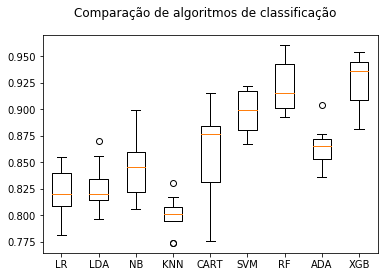

In [41]:
num_folds = 10
seed = 7

X = datasetCombinado.iloc[:,0:19]
Y = datasetCombinado.iloc[:,19]

modelos = []
modelos.append(('LR',LogisticRegression()))
modelos.append(('LDA',LinearDiscriminantAnalysis()))
modelos.append(('NB',GaussianNB()))
modelos.append(('KNN',KNeighborsClassifier()))
modelos.append(('CART',DecisionTreeClassifier()))
modelos.append(('SVM',SVC()))
modelos.append(('RF',RandomForestClassifier()))
modelos.append(('ADA',AdaBoostClassifier()))
modelos.append(('XGB',XGBClassifier(use_label_encoder = False)))


resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds,shuffle = True, random_state = seed)
    cv_results = cross_val_score(modelo, X, Y, cv = kfold, scoring = 'roc_auc')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" %(nome, cv_results.mean(),cv_results.std())
    print(msg)

    
fig = plt.figure()
fig.suptitle('Comparação de algoritmos de classificação')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

In [42]:
#Verificamos acima que os algoritmos Randomforest e XGBClassifier mostraram a melhor performance para esse conjunto de dados
#Dessa forma seguirei com os dois afim de avaliar qual é mais adequado

Acurácia = 0.95, 
Recall = 0.68 
Precision = 0.96


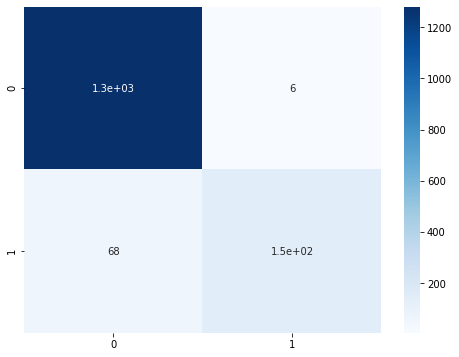

In [43]:
num_folds = 10
seed = 7

num_trees = 100
max_features = 3

model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
testeDataset(datasetCombinado, model)

[15:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia = 0.95, 
Recall = 0.72 
Precision = 0.91


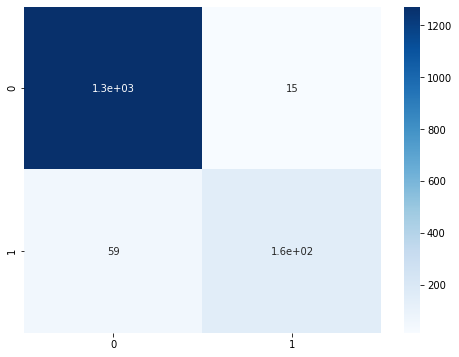

In [44]:
num_folds = 10
seed = 7

num_trees = 100
max_features = 3

model = XGBClassifier(n_estimators=num_trees, use_label_encoder = False)
testeDataset(datasetCombinado, model)

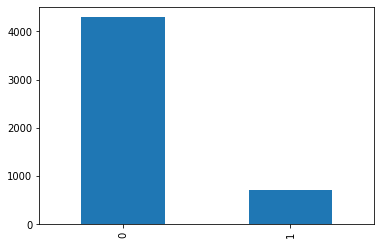

In [45]:
# o dataset está extramanente desbalanceado
# isso acabo trazendo uma métrica e recal não muito boa
datasetCombinado.churn.value_counts().plot.bar()

In [46]:
# não é que o resultado acima esteja péssimo, mas tentarei utilizar o smote para ajudar a melhorar

In [47]:
sm = SMOTE(random_state = 7)

xSmote, ySmote = sm.fit_resample(datasetCombinado.iloc[:,0:19],datasetCombinado.iloc[:,19])

datasetSmotedScaled = pd.DataFrame(xSmote)
datasetSmotedScaled["churn"] = ySmote

[15:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia = 0.97, 
Recall = 0.96 
Precision = 0.98


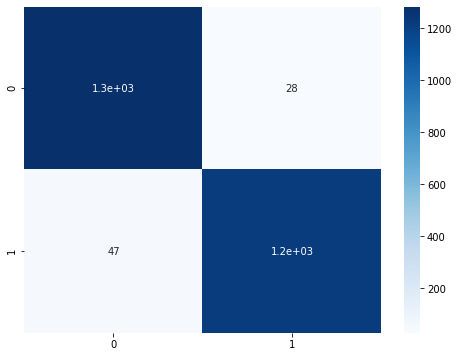

In [48]:
num_folds = 10
seed = 7

num_trees = 100
max_features = 3

model = XGBClassifier(n_estimators=num_trees, use_label_encoder = False)
testeDataset(datasetSmotedScaled, model)

In [49]:
%%time

x = datasetCombinado.iloc[:, 0:19]
y = datasetCombinado.iloc[:,19]

param_test1 = {
 'max_depth':[3,4,5,6,7],
 'min_child_weight':[1,2,3]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic',  scale_pos_weight=1, seed=seed, use_label_encoder = False), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(x, y)

# Print do resultado
print("Acurácia: %.3f" % (gsearch1.best_score_ * 100))
print("Melhores Parâmetros do Modelo:\n", gsearch1.best_estimator_)


[15:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia: 92.336
Melhores Parâmetros do Modelo:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=7, subsample=0.8, tree_method='exact',
              use_label_encoder=False,

In [50]:
gsearch1.best_params_

{'max_depth': 4, 'min_child_weight': 2}

[15:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia = 0.96, 
Recall = 0.95 
Precision = 0.97


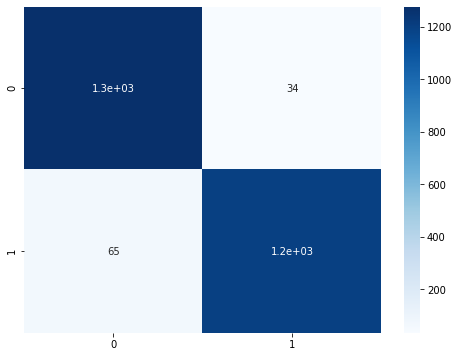

In [51]:
model = XGBClassifier(learning_rate =0.01, n_estimators=3000, max_depth=4,
                         min_child_weight=2, use_label_encoder = False)

testeDataset(datasetSmotedScaled, model)

In [52]:
datasetTreino = datasetScaler(transformDataset(pd.read_csv("projeto4_telecom_treino.csv").drop("Unnamed: 0", axis = 1)))
datasetTeste = datasetScaler(transformDataset(pd.read_csv("projeto4_telecom_teste.csv").drop("Unnamed: 0", axis = 1)))

In [53]:
datasetTreino.describe()

state  account_length    area_code  international_plan  \
count  3333.000000     3333.000000  3333.000000         3333.000000   
mean      0.485383        0.413491     0.500300            0.096910   
std       0.294731        0.164554     0.354824            0.295879   
min       0.000000        0.000000     0.000000            0.000000   
25%       0.240000        0.301653     0.000000            0.000000   
50%       0.480000        0.413223     0.500000            0.000000   
75%       0.740000        0.520661     1.000000            0.000000   
max       1.000000        1.000000     1.000000            1.000000   

       voice_mail_plan  number_vmail_messages  total_day_minutes  \
count      3333.000000            3333.000000        3333.000000   
mean          0.276628               0.158804           0.512472   
std           0.447398               0.268399           0.155266   
min           0.000000               0.000000           0.000000   
25%           0.000000               0.000000           0.409635   
50%           0.000000               0.000000           0.511403   
75%           1.000000               0.392157           0.616876   
max           1.000000               1.000000           1.000000   

       total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
count      3333.000000       3333.000000        3333.000000      3333.000000   
mean          0.608701          0.512446           0.552599         0.588908   
std           0.121631          0.155255           0.139439         0.117192   
min           0.000000          0.000000           0.000000         0.000000   
25%           0.527273          0.409624           0.458070         0.511765   
50%           0.612121          0.511402           0.553753         0.588235   
75%           0.690909          0.616868           0.646962         0.670588   
max           1.000000          1.000000           1.000000         1.000000   

       total_eve_charge  total_night_minutes  total_night_calls  \
count       3333.000000          3333.000000        3333.000000   
mean           0.552687             0.477870           0.472590   
std            0.139459             0.136024           0.137807   
min            0.000000             0.000000           0.000000   
25%            0.458104             0.386767           0.380282   
50%            0.553866             0.478752           0.471831   
75%            0.647040             0.570468           0.563380   
max            1.000000             1.000000           1.000000   

       total_night_charge  total_intl_minutes  total_intl_calls  \
count         3333.000000         3333.000000       3333.000000   
mean             0.478143            0.511865          0.223972   
std              0.136035            0.139592          0.123061   
min              0.000000            0.000000          0.000000   
25%              0.387328            0.425000          0.150000   
50%              0.478781            0.515000          0.200000   
75%              0.570831            0.605000          0.300000   
max              1.000000            1.000000          1.000000   

       total_intl_charge  number_customer_service_calls        churn  
count        3333.000000                    3333.000000  3333.000000  
mean            0.511960                       0.173651     0.144914  
std             0.139588                       0.146166     0.352067  
min             0.000000                       0.000000     0.000000  
25%             0.425926                       0.111111     0.000000  
50%             0.514815                       0.111111     0.000000  
75%             0.605556                       0.222222     0.000000  
max             1.000000                       1.000000     1.000000

In [54]:
datasetTeste.describe()

state  account_length    area_code  international_plan  \
count  1667.000000     1667.000000  1667.000000         1667.000000   
mean      0.486023        0.412011     0.495501            0.089982   
std       0.297247        0.166248     0.352249            0.286242   
min       0.000000        0.000000     0.000000            0.000000   
25%       0.220000        0.299578     0.000000            0.000000   
50%       0.480000        0.409283     0.500000            0.000000   
75%       0.740000        0.527426     0.500000            0.000000   
max       1.000000        1.000000     1.000000            1.000000   

       voice_mail_plan  number_vmail_messages  total_day_minutes  \
count      1667.000000            1667.000000        1667.000000   
mean          0.240552               0.135919           0.506571   
std           0.427547               0.254524           0.152891   
min           0.000000               0.000000           0.000000   
25%           0.000000               0.000000           0.397651   
50%           0.000000               0.000000           0.505654   
75%           0.000000               0.000000           0.606408   
max           1.000000               1.000000           1.000000   

       total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
count      1667.000000       1667.000000        1667.000000      1667.000000   
mean          0.517596          0.506554           0.527149         0.475911   
std           0.153390          0.152872           0.149059         0.149908   
min           0.000000          0.000000           0.000000         0.000000   
25%           0.412698          0.397681           0.426113         0.381679   
50%           0.515873          0.505628           0.528487         0.473282   
75%           0.619048          0.606412           0.623145         0.572519   
max           1.000000          1.000000           1.000000         1.000000   

       total_eve_charge  total_night_minutes  total_night_calls  \
count       1667.000000          1667.000000        1667.000000   
mean           0.527092             0.522618           0.585543   
std            0.149084             0.132172           0.121867   
min            0.000000             0.000000           0.000000   
25%            0.425978             0.436583           0.505882   
50%            0.528282             0.522537           0.582353   
75%            0.623080             0.610718           0.664706   
max            1.000000             1.000000           1.000000   

       total_night_charge  total_intl_minutes  total_intl_calls  \
count         1667.000000         1667.000000       1667.000000   
mean             0.522688            0.523388          0.228775   
std              0.132184            0.137039          0.128750   
min              0.000000            0.000000          0.000000   
25%              0.436808            0.436548          0.157895   
50%              0.522423            0.527919          0.210526   
75%              0.610949            0.609137          0.263158   
max              1.000000            1.000000          1.000000   

       total_intl_charge  number_customer_service_calls        churn  
count        1667.000000                    1667.000000  1667.000000  
mean            0.523387                       0.226498     0.134373  
std             0.136986                       0.184026     0.341155  
min             0.000000                       0.000000     0.000000  
25%             0.436090                       0.142857     0.000000  
50%             0.528195                       0.142857     0.000000  
75%             0.609023                       0.285714     0.000000  
max             1.000000                       1.000000     1.000000

In [55]:
x_treino = datasetTreino.iloc[:,0:19]
y_treino = datasetTreino.iloc[:,19]
x_teste = datasetTeste.iloc[:,0:19]
y_teste = datasetTeste.iloc[:,19]

model = XGBClassifier(learning_rate =0.01, n_estimators=5000, max_depth=4,
                         min_child_weight=2, use_label_encoder = False)
#

#model = RandomForestClassifier(n_estimators=1000)

model.fit(x_treino,y_treino)

[15:23:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [56]:
predicoes = model.predict(x_teste)

Acurácia = 0.90, 
Recall = 0.76 
Precision = 0.61


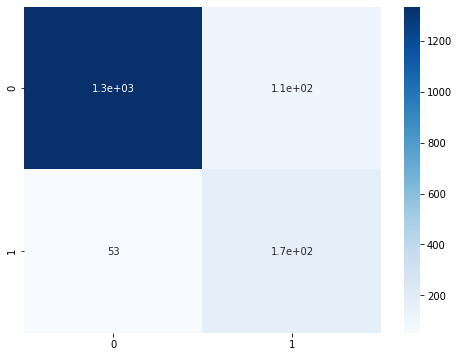

In [57]:
accuracy = accuracy_score(y_teste, predicoes)
recall = recall_score(y_teste, predicoes)
precision = precision_score(y_teste, predicoes)
print("Acurácia = %.2f, \nRecall = %.2f \nPrecision = %.2f" % (accuracy, recall,precision))
cm = confusion_matrix(y_teste, predicoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, cmap = "Blues")

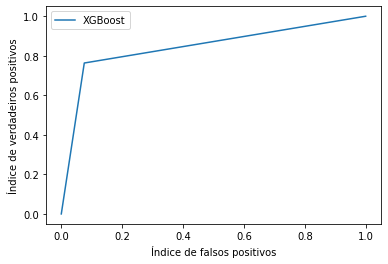

In [58]:
xgb_fpr, xgb_tpr, _ = roc_curve(y_teste, predicoes)

plt.plot(xgb_fpr, xgb_tpr, linestyle = "solid", label = "XGBoost")

plt.xlabel('Índice de falsos positivos')
plt.ylabel('Índice de verdadeiros positivos')

plt.legend()

plt.show()

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [60]:
x_treino = datasetTreino.iloc[:,0:19]
y_treino = datasetTreino.iloc[:,19]
x_teste = datasetTeste.iloc[:,0:19]
y_teste = datasetTeste.iloc[:,19]

modelos = []
modelos.append(('LR',LinearRegression()))
modelos.append(('Ridge',Ridge()))
modelos.append(('SVR',SVR()))
modelos.append(('RFR',RandomForestRegressor()))
modelos.append(('Elast',ElasticNet()))
modelos.append(('KNN',KNeighborsRegressor()))

nomes = []

for nome, modelo in modelos:
    modelo.fit(x_treino,y_treino)
    pred = modelo.predict(x_teste)
    mse = mean_squared_error(pred,y_teste)
    
    msg = "%s: %f " %(nome, mse)
    print(msg)

LR: 0.096106 
Ridge: 0.095808 
SVR: 0.072096 
RFR: 0.092662 
Elast: 0.116428 
KNN: 0.088230 
